In [43]:
import findspark
findspark.init()
import pyspark

In [3]:
import os
import sys
print(sys.executable)
print(os.environ['JAVA_HOME'])
print(os.environ['SPARK_HOME'])

/anaconda3/envs/ada/bin/python
/Library/Java/JavaVirtualMachines/jdk1.8.0_192.jdk/Contents/Home
/Users/Spark


In [44]:
import pandas as pd
import numpy as np

from pyspark.sql import *
from pyspark.sql.types import *

from pyspark.sql.functions import explode
from pyspark.sql.functions import split

from pyspark.sql.functions import udf
#from pyspark.sql.functions import col

import matplotlib.pyplot as plt

In [5]:
spark = SparkSession.builder.getOrCreate()

# Openfoodfact data 

In [111]:
#We load the entire OpenFoodFacts file

df_data = spark.read.option("sep", "\t").option("header", True).csv('./data.csv')

In [110]:
#df_data

We check which countries are the most represented in the datafile.

For the nutri-score part, we first decided to focus on three countries: France, United-States and switzerland.

France, because the OpenFactFood project was initiated by a french man, in France. Thus, it is the country for which we have the most data. The United States because it is the second country in term of number of data and because it is a far away country, known for its obesity problems. And finally, switzerland, because we also have numerous data, because it is the country where we live, and because we wanted to know if people in this 'rich' country consumes more healthy than in other countries.

In [112]:
#We split the countries_tags column to have single countries in each row.
#Then we count the occurrence of each country, and order them from the bigger to the smaller count.

countries = df_data.select(explode(split('countries_tags', ','))).withColumnRenamed("col", "countries_tags")
#countries.show(200)

counted_countries = countries.groupBy('countries_tags').count().sort("count", ascending = False)
counted_countries.show()

+-----------------+------+
|   countries_tags| count|
+-----------------+------+
|        en:france|446394|
| en:united-states|175478|
|       en:germany| 19489|
|   en:switzerland| 19365|
|       en:belgium|  9735|
|         en:spain|  8341|
|en:united-kingdom|  8086|
|        en:canada|  3805|
|         en:italy|  3035|
|     en:australia|  2694|
|        en:mexico|  2360|
|        en:russia|  2203|
|   en:netherlands|  1548|
|        en:sweden|  1526|
|      en:portugal|  1441|
|       en:denmark|   949|
|       en:austria|   928|
|       en:romania|   799|
|en:czech-republic|   646|
|       en:hungary|   643|
+-----------------+------+
only showing top 20 rows



Then, we wanted to see the most represented categories, to be able to treat not only the entire dataset, but also interesting sub-datasets.

In [8]:
#We split the categories_tags column to have single categories in each row.
#Then we count the occurrence of each category, and order them from the bigger to the smaller count.

categories = df_data.select(explode(split('categories_tags', ','))).withColumnRenamed("col", "categories_tags")
#categories.show(200, False)

counted_categories = categories.groupBy('categories_tags').count().sort("count", ascending = False)
counted_categories.show(20, False)

+------------------------------------+-----+
|categories_tags                     |count|
+------------------------------------+-----+
|en:plant-based-foods-and-beverages  |51261|
|en:plant-based-foods                |43981|
|en:beverages                        |29798|
|en:sugary-snacks                    |26277|
|en:dairies                          |18477|
|en:non-alcoholic-beverages          |16523|
|en:meals                            |15601|
|en:fruits-and-vegetables-based-foods|15362|
|en:cereals-and-potatoes             |15324|
|en:fermented-foods                  |12164|
|en:fermented-milk-products          |12127|
|en:biscuits-and-cakes               |11895|
|en:spreads                          |10928|
|en:cereals-and-their-products       |9792 |
|en:meats                            |9686 |
|en:groceries                        |9583 |
|en:breakfasts                       |9547 |
|en:desserts                         |9091 |
|en:plant-based-beverages            |8633 |
|en:fruits

In [26]:
#We define the colors corresponding to the Nutri-score for our following plots
#We chose the re-use the 'official' colors from the website

score_colors =['green', 'lightgreen', 'yellow', 'orange','red']

# France data

### Overall

In [46]:
#We create a dataframe with all the data for France

df_france = df_data.where(df_data.countries_tags.contains('en:france')).select('product_name','categories_tags','nutrition_grade_fr', 'nutrition-score-fr_100g')
#df_france.show(200)

In [26]:
df_france.count()

446394

In [121]:
#We drop the Null rows, as this values cannot be treated

df_france = df_france.na.drop()
df_france.show(10)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|  Tarte noix de coco|en:pies,en:sweet-...|                 d|                     14|
|    Compote de poire|en:plant-based-fo...|                 a|                     -4|
|    BAguette bressan|en:plant-based-fo...|                 a|                     -4|
|Pavé de saumon fu...|en:seafood,en:fis...|                 d|                     15|
|  Stylo glaçage gris| en:food-decorations|                 e|                     29|
|Blanquette de Vol...|en:meals,en:meat-...|                 b|                      0|
|Raviolini au From...|en:meals,en:micro...|                 b|                      1|
|           Root Beer|en:beverages,en:c...|                 e|                     12|
|A&w - Root Beer -...|en:beverages,en:n...|

In [80]:
total_france = df_france.count()
total_france

116780

We see that on the 446394 products we had, only 116780 are exploitable here, that is around 1/4 of the data.

In [117]:
#We count the number of products we have for the different Nutri-Score (from a to e)

counted_nutriscore_fr = df_france.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
counted_nutriscore_fr.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|15270|
|                 b|16192|
|                 c|24137|
|                 d|34280|
|                 e|26901|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

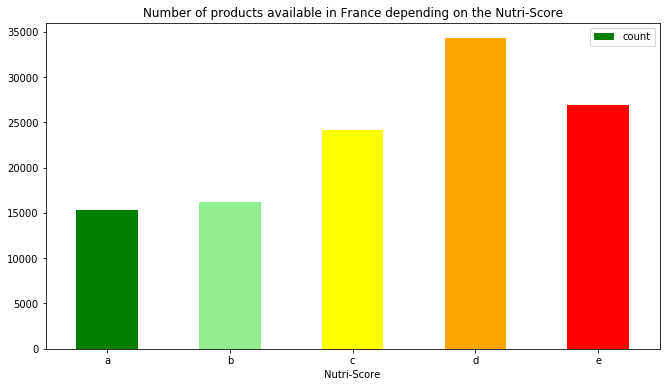

In [118]:
#We create a panda dataframe from the spark dataframe
#Then we plot our results

pd_nutriscore_france = counted_nutriscore_fr.toPandas()

pd_nutriscore_france.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color=score_colors)
plt.title("Number of products available in France depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

### Beverages

In [122]:
#Then we re-do the same but only for the products in the "beverage" category

#We create a new dataframe with all the beverages, in France

france_beverages = df_france.filter(df_france.categories_tags.contains("en:beverages"))
france_beverages.show(10)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|           Root Beer|en:beverages,en:c...|                 e|                     12|
|A&w - Root Beer -...|en:beverages,en:n...|                 e|                     16|
|Thé noir aromatis...|en:beverages,en:n...|                 c|                      2|
|Pepsi, Nouveau go...|en:beverages,en:c...|                 e|                     13|
|Blle Pet 50CL Coc...|en:beverages,en:s...|                 e|                     14|
|                 7Up|en:plant-based-fo...|                 e|                     13|
|Smoothie Strawber...|en:plant-based-fo...|                 e|                     12|
|      Ruby breakfast|en:beverages,en:n...|                 e|                     14|
|Iced Tea Spanish ...|en:beverages,en:r...|

In [36]:
tot_bev_france = france_beverages.count()
tot_bev_france

15419

Over the 116780 exploitable datas for France, 15419 are beverages, that is between 1/7 and 1/8 of these datas.

In [119]:
#We count the number of beverages we have for the different Nutri-Score (from a to e)

beverage_nutriscore_fr = france_beverages.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
beverage_nutriscore_fr.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|  238|
|                 b| 2632|
|                 c| 2826|
|                 d| 2495|
|                 e| 7228|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

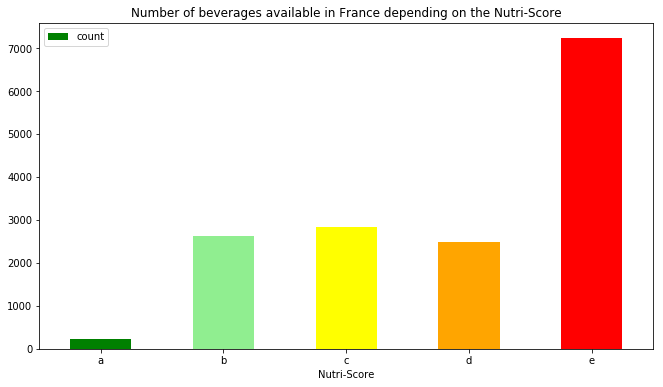

In [120]:
#We create a panda dataframe from the spark dataframe

pd_beverages_france = beverage_nutriscore_fr.toPandas()

#We plot our results

pd_beverages_france.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color=score_colors)
plt.title("Number of beverages available in France depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

# Switzerland data

In [53]:
#We create a new dataframe for the datas for Switzerland

df_switzerland = df_data.where(df_data.countries_tags.contains('en:switzerland')).select('product_name','categories_tags','nutrition_grade_fr', 'nutrition-score-fr_100g')
#df_switzerland.show(200)

In [44]:
df_switzerland.count()

19365

In [123]:
#We drop the Null values

df_switzerland = df_switzerland.na.drop()
df_switzerland.show(10)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|             Nutella|en:petit-dejeuner...|                 e|                     24|
|                skyr|en:dairies,en:fer...|                 a|                     -5|
|Chocolate Chunk D...|en:sugary-snacks,...|                 e|                     21|
|Chocolate Chunk M...|en:sugary-snacks,...|                 e|                     22|
|Poires demi-fruit...|en:plant-based-fo...|                 a|                     -3|
|  Pêches Demi-Fruits|en:plant-based-fo...|                 a|                     -3|
|Cocktail de fruit...|en:plant-based-fo...|                 a|                     -3|
|Mandarines au sir...|en:plant-based-fo...|                 a|                     -3|
|  Cocktail de fruits|en:plant-based-fo...|

In [81]:
total_switz = df_switzerland.count()
total_switz

4463

Here again, around 1/4 of the data are exploitable. (4463 over 19365)

In [55]:
#We count the number of products we have for the different Nutri-Score (from a to e)

counted_nutriscore_s = df_switzerland.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
counted_nutriscore_s.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|  723|
|                 b|  664|
|                 c|  897|
|                 d| 1220|
|                 e|  959|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

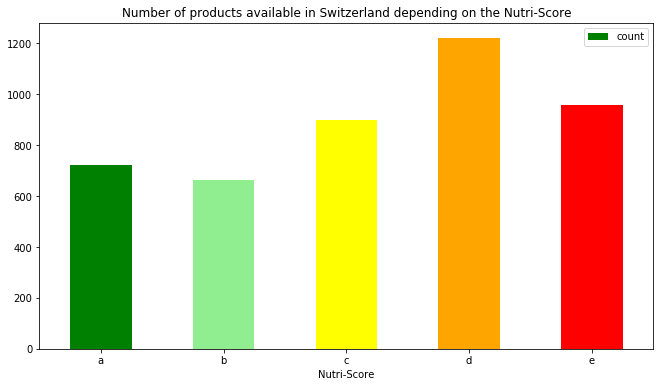

In [56]:
#We create a panda dataframe from the spark dataframe

pd_nutriscore_switzerland = counted_nutriscore_s.toPandas()

#Then we plot our results

pd_nutriscore_switzerland.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color= score_colors)
plt.title("Number of products available in Switzerland depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

### Beverages

In [124]:
#We do it again for the beverages in Switzerland

switzerland_beverages = df_switzerland.filter(df_switzerland.categories_tags.contains("en:beverages"))
switzerland_beverages.show(10)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|Of London Camomil...|en:beverages,en:n...|                 b|                      1|
|Blended Scotch Wh...|en:beverages,en:w...|                 e|                     11|
|        jus de pomme|en:plant-based-fo...|                 c|                      4|
|Original green te...|en:beverages,en:i...|                 d|                      9|
|Pomegrenate Green...|en:plant-based-fo...|                 e|                     11|
| Blueberry white tea|en:beverages,en:s...|                 e|                     11|
|Arizona Lite Half...|en:beverages,en:a...|                 d|                      7|
|Watermelon Chewes...|en:plant-based-fo...|                 e|                     11|
|Boisson lactée à ...|en:beverages,en:d...|

In [82]:
tot_bev_switz = switzerland_beverages.count()
tot_bev_switz

537

Over the 4463 exploitable data we have for switzerland, 537 are beverages, that is around 1/8 of these data.

In [58]:
#We count the number of beverages for the different nutri-score in switzerland

beverage_score_switz = switzerland_beverages.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
beverage_score_switz.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|   18|
|                 b|   98|
|                 c|  120|
|                 d|  116|
|                 e|  185|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

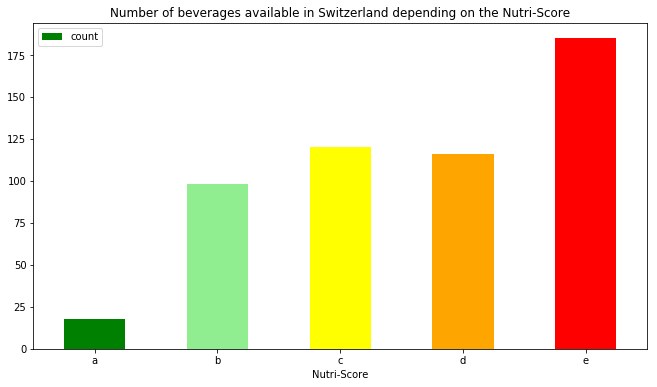

In [59]:
#We create a panda dataframe from the spark dataframe

pd_beverages_switzerland = beverage_score_switz.toPandas()

#We plot our results

pd_beverages_switzerland.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color=score_colors)
plt.title("Number of beverages available in Switzerland depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

# United states datas

In [113]:
#We create a dataframe for the United States data

df_usa = df_data.where(df_data.countries_tags.contains('en:united-states')).select('product_name','categories_tags','nutrition_grade_fr', 'nutrition-score-fr_100g')
#df_usa.show(200)

In [54]:
df_usa.count()

175479

In [125]:
#We drop the null values

df_usa = df_usa.na.drop()
df_usa.show(10)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|           Root Beer|en:beverages,en:c...|                 e|                     12|
|  Sliced Plain Bagel|      en:pains-bagel|                 c|                      3|
|Sea Salt Potato C...|en:chips-and-frie...|                 c|                      8|
|        clam chowder|en:meals,en:soups...|                 b|                      2|
|      Pizza Parlanno|en:meals,en:pizza...|                 d|                     11|
|       Mac 'n Cheese|en:meals,en:micro...|                 c|                      4|
|      Yellow Mustard|en:groceries,en:c...|                 b|                      0|
|Vanilla Nonfat Yo...|en:dairies,en:fer...|                 a|                     -1|
|          Tortellini|en:plant-based-fo...|

In [115]:
total_usa = df_usa.count()
total_usa

2685

Over the 175479 data we have for the United States, 2685 are exploitable, that is only 1/65 !

We see that only a very few datas are exploitable for the United States, even though it is a very big country.

Thus we must be careful when we interpret our results. This data may not represent very well the United States.

In [62]:
#We count the number of products for each nutri-score in the united states

counted_nutriscore_usa = df_usa.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
counted_nutriscore_usa.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|  336|
|                 b|  432|
|                 c|  496|
|                 d|  862|
|                 e|  559|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

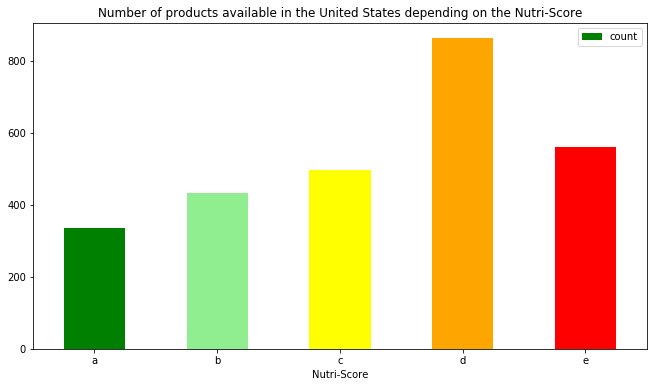

In [63]:
#We create a panda dataframe from the spark dataframe, then we plot our results

pd_nutriscore_usa = counted_nutriscore_usa.toPandas()

pd_nutriscore_usa.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color= score_colors)
plt.title("Number of products available in the United States depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

### Beverages

In [126]:
# We select the beverages, in a new dataframe we create

usa_beverages = df_usa.filter(df_usa.categories_tags.contains("en:beverages"))
usa_beverages.show(10)

+--------------------+--------------------+------------------+-----------------------+
|        product_name|     categories_tags|nutrition_grade_fr|nutrition-score-fr_100g|
+--------------------+--------------------+------------------+-----------------------+
|           Root Beer|en:beverages,en:c...|                 e|                     12|
|         Ginger Beer|en:plant-based-fo...|                 e|                     14|
|D' Sabor, Aloe Ve...|en:plant-based-fo...|                 e|                     10|
|D' Sabor, Aloe Ve...|en:plant-based-fo...|                 e|                     10|
|100% Juice Unfilt...|en:plant-based-fo...|                 c|                      5|
|100% Juice Apple ...|en:plant-based-fo...|                 c|                      5|
|    100% Apple Juice|en:plant-based-fo...|                 c|                      5|
|   100% Juice, Apple|en:plant-based-fo...|                 c|                      5|
|    100% Apple Juice|en:plant-based-fo...|

In [38]:
tot_bev_usa = usa_beverages.count()
tot_bev_usa

342

Over the 2685 exploitable data for the United States, 342 are beverages, that is around 1/8.

In [65]:
#We count the number of beverages for each nutri-score

beverage_score_usa = usa_beverages.groupBy('nutrition_grade_fr').count().sort("nutrition_grade_fr")
beverage_score_usa.show()

+------------------+-----+
|nutrition_grade_fr|count|
+------------------+-----+
|                 a|    7|
|                 b|   55|
|                 c|   62|
|                 d|   67|
|                 e|  151|
+------------------+-----+



Text(0.5, 0, 'Nutri-Score')

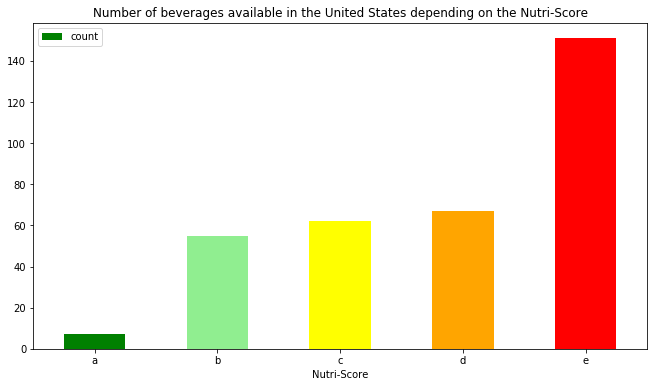

In [116]:
#We create a panda dataframe from the spark dataframe

pd_beverages_usa = beverage_score_usa.toPandas()

#Then we plot our results

pd_beverages_usa.plot.bar(x= 'nutrition_grade_fr', y = 'count', rot=0, figsize=(11,6), color=score_colors)
plt.title("Number of beverages available in the United States depending on the Nutri-Score")
plt.xlabel("Nutri-Score")

# Overall comparison

In this part we want to directly compare the proportion of each Nutri-Score (a, b, c, d and e), for the different countries.

As the datasets for the different countries have different sizes, we need to use percentages to be able to do the comparison.

In [129]:
#We calculate the percentages for the different nutri-score for each country

nb_lines = len(pd_nutriscore_france.iloc[:,0])

France_percent = []
Switzerland_percent = []
United_States_percent = []
nutri_score = []

for i in range (0, nb_lines):
    nutri_score.append(pd_nutriscore_france.iloc[i, 0])
    France_percent.append(pd_nutriscore_france.iloc[i,1]/total_france*100)
    Switzerland_percent.append(pd_nutriscore_switzerland.iloc[i,1]/total_switz*100)
    United_States_percent.append(pd_nutriscore_usa.iloc[i,1]/total_usa*100)


In [130]:
#We create a panda dataframe with these percentages

df_comparison = pd.DataFrame({'France': France_percent, 'Switzerland': Switzerland_percent, 'United States': United_States_percent, 'Nutri-score': nutri_score}).set_index('Nutri-score')

df_comparison

,France,Switzerland,United States
Nutri-score,,,
a,13.075869,16.199866,12.513966
b,13.865388,14.877885,16.089385
c,20.668779,20.098588,18.472998
d,29.354341,27.335873,32.104283
e,23.035623,21.487788,20.819367


Text(0, 0.5, 'Percentage')

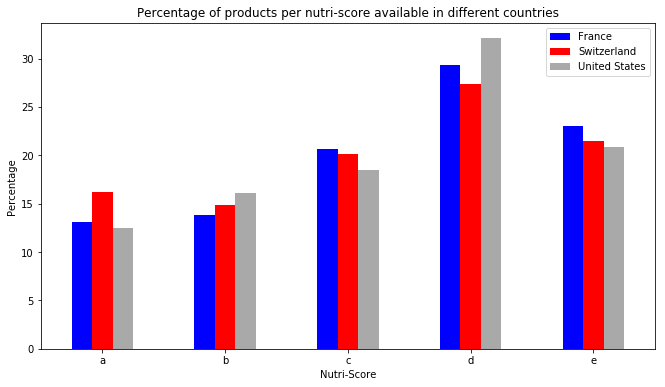

In [131]:
#Then we plot our results

df_comparison.plot.bar(rot=0, figsize=(11,6), color=('b', 'r', 'darkgrey'))

plt.title("Percentage of products per nutri-score available in different countries")
plt.xlabel("Nutri-Score")
plt.ylabel("Percentage")

### Beverages

In [132]:
#This time we calculate the percentages for the different nutri-score for each country for the beverages

nb_lines = len(pd_beverages_france.iloc[:,0])

France_bev_percent = []
Switzerland_bev_percent = []
United_States_bev_percent = []
#nutri_score = []

for i in range (0, nb_lines):
  #  nutri_score.append(pd_nutriscore_france.index[i])
    France_bev_percent.append(pd_beverages_france.iloc[i,1]/tot_bev_france*100)
    Switzerland_bev_percent.append(pd_beverages_switzerland.iloc[i,1]/tot_bev_switz*100)
    United_States_bev_percent.append(pd_beverages_usa.iloc[i,1]/tot_bev_usa*100)



In [133]:
#We create a panda dataframe with these percentages

df_comparison_beverages = pd.DataFrame({'France': France_bev_percent, 'Switzerland': Switzerland_bev_percent, 'United States': United_States_bev_percent, 'Nutri-score': nutri_score}).set_index('Nutri-score')

df_comparison_beverages

,France,Switzerland,United States
Nutri-score,,,
a,1.543550,3.351955,2.046784
b,17.069849,18.249534,16.081871
c,18.328037,22.346369,18.128655
d,16.181335,21.601490,19.590643
e,46.877229,34.450652,44.152047


Text(0, 0.5, 'Percentage')

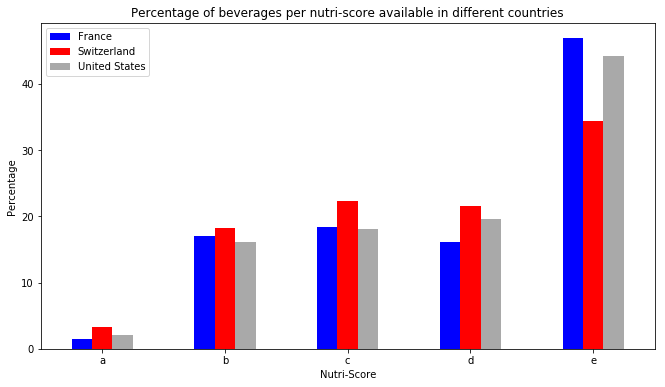

In [134]:
#Then we plot our results

df_comparison_beverages.plot.bar(rot=0, figsize=(11,6), color=('b', 'r', 'darkgrey'))

plt.title("Percentage of beverages per nutri-score available in different countries")
plt.xlabel("Nutri-Score")
plt.ylabel("Percentage")

First, we need to be careful, because the dataset we have is not complete. A lot of products are still not on the OpenFactFood website, and thus are not treated. Furthermore, the product we have are products available in the countries, but we do not know how popular they are, and if people do consume them a lot or not.

Here, we do not see any big difference between France, Switzerland and the United States.
It could be biaised due to the fact that the majority of the products in the United States are not on the website already.

Maybe we should then focus on much more specific and thus much smaller dataset.

The overall tendency for all the products is an increase in number as the Nutri-Score increases from a to d, and then a small decrease from d to e.

For the beverages, we observe an important increase in number of products available as the Nutri-Score increases from a to e. 

It means that the majority of the products available in supermarket have low nutritional values.